Lauri Reima <br>
Student number 2109673 <br>
February, 6th, 2024  <br>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2024

### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b> <br>

<b> Instructions: </b> 

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score (using sklearn.preprocessing.StandardScaler is advised).
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Explain your code by adding detailed comments. 
    - Only provide code that is relevant to the exercise.
    - Please submit your solution as a Jupyter Notebook (.ipynb) and as a PDF file. Ensure to include your full name in the filename.     
    - Submit to moodle your solution on ** Wednesday 7 of February ** at the latest.
  
<b>Please follow the instructions and note that you are expected to submit your individual solution.<br>
Identical or overly similar submissions will result in the exercise being marked as failed.
</b>

## Import libraries

In [1]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,  LeaveOneOut, KFold, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

## Read and visualize the dataset

In [2]:
# In this cell read the file Water_data.csv
# Print the dataset dimesions (i.e. number of rows and columns)
# Print the first 5 rows of the dataset
water_data = pd.read_csv('water_data.csv')
print(water_data.shape)
print(water_data.head(5))

(268, 6)
    Mod1  Mod2    Mod3  c_total   Cd    Pb
0   9945   119   72335        0  0.0   0.0
1   9596   119  110542        0  0.0   0.0
2  10812   120   98594        0  0.0   0.0
3  10786   117   82977        0  0.0   0.0
4  10566   108  136416       14  0.0  14.0


## Standardization of the dataset

In [3]:
# In this cell, standardize the dataset features by removing the mean and scaling to unit variance. 
# In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
# Print the 5 first samples (i.e. rows) of the scaled dataset

# I made my own function to calculate the z-score in a given data and column
def zstand(data, col, x):
    mean = data[col].mean()
    std = np.std(data[col])
    return (x-mean)/std
    
# a function to change the values to standardized form
def cols_to_z(data,cols):
    for col in cols:
        data[col] = data[col].apply(lambda x: zstand(data, col, x))

standardized = water_data.copy()
cols_to_z(standardized, ['Mod1', 'Mod2', 'Mod3'])
standardized.head(5)

,Mod1,Mod2,Mod3,c_total,Cd,Pb
0,-0.972283,-0.670482,-0.358179,0,0.0,0.0
1,-0.975878,-0.670482,0.259488,0,0.0,0.0
2,-0.963351,-0.670394,0.066333,0,0.0,0.0
3,-0.963619,-0.670657,-0.186137,0,0.0,0.0
4,-0.965885,-0.671447,0.677776,14,0.0,14.0


## C-index code 

In [4]:
# In this cell, implement the C-index function. You may use the implementation from the first exercise.
def cindex(true_labels, pred_labels):
    n = 0
    h_num = 0 
    for i in range(len(true_labels)):
        for j in range(i+1, len(true_labels)):
            if (true_labels[i] != true_labels[j]): 
                n += 1
                if (pred_labels[i] < pred_labels[j] and true_labels[i] < true_labels[j]) or (pred_labels[i] > pred_labels[j] and true_labels[i] > true_labels[j]): 
                    h_num += 1
                elif (pred_labels[i] == pred_labels[j]):
                    h_num += 0.5
    # just for errorhandling 
    if n == 0:
        return 0
    cindx = h_num/n
    """Returns C-index between true labels and predicted labels"""         
    return cindx

In [5]:
# Test the cindex function with following values
true_labels = np.array([-1, 1, 1, -1, 1])
predictions = np.array([0.60, 0.80, 0.75, 0.75, 0.70])
cindx = cindex(true_labels, predictions)
print(cindx) #For this example, a correct C-index implementation will result in 0.75

0.75


## Leave-One-Out cross-validation
In the following cell, write and execute your code for Leave-One-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-One-Out C-index for c_total, Cd and Pb for each k value.

In [6]:
k_values = [1,3,5,7]
col_names = ['c_total', 'Cd', 'Pb']

n = len(standardized)
loo_df = pd.DataFrame(columns=['variable', 'k', 'C-index'])
for col in col_names:
    
    X = standardized.drop(col_names, axis=1)
    y = standardized[col]

    for k in k_values:
        
        knn = KNeighborsRegressor(n_neighbors=k, metric= 'euclidean')
        c_index_values = []
        loo = LeaveOneOut()
     
        y_value_arr = []
        y_pred_arr = []

        for train_ind, test_ind in loo.split(X):
            X_train = X.iloc[train_ind]
            X_test = X.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            y_pred_arr.extend(y_pred)
            y_value_arr.extend(y_test.values)
            #print(f"true: {y_test}, pred: {y_pred}")
        c_index_values.append(cindex(y_value_arr, y_pred_arr))
       
        temp_df = pd.DataFrame({'variable': [col], 'k': [k], 'C-index': [np.mean(c_index_values)]})

        loo_df = pd.concat([loo_df, temp_df], ignore_index=True)
grouped_loo_df = loo_df.groupby('variable')

for name, group in grouped_loo_df:
    print(f"Group: {name}")
    print(group)
    print("\n")

Group: Cd
  variable  k   C-index
4       Cd  1  0.913592
5       Cd  3  0.912488
6       Cd  5  0.866349
7       Cd  7  0.831597


Group: Pb
   variable  k   C-index
8        Pb  1  0.879590
9        Pb  3  0.884710
10       Pb  5  0.860935
11       Pb  7  0.841043


Group: c_total
  variable  k   C-index
0  c_total  1  0.908098
1  c_total  3  0.920363
2  c_total  5  0.896185
3  c_total  7  0.883905




## Leave-Replicas-Out cross-validation

In the following cell, write and execute your code for Leave-Replicas-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-Replicas-Out C-index for c_total, Cd and Pb for each k value.

In [7]:
col_names = ['c_total', 'Cd', 'Pb']
target = standardized[col_names]


group = target.groupby(list(target.columns)).apply(lambda x: x.index.tolist()).tolist()
groups = []
for i in range(len(group)):
    for j in range(len(group[i])):
        groups.append(i)
logo_groups = np.array(groups)

logo_df = pd.DataFrame(columns=['variable', 'k', 'C-index'])
k_values = [1,3,5,7]
n = len(standardized)
features = ['Mod1', 'Mod2', 'Mod3']
Scores_logo = {
    'c_total': [],
    'Cd': [],
    'Pb': []
}
for col in col_names:
    X = standardized[features].values
    y = standardized[col].values
    col_values = []
    for k in k_values:
        
        knn = KNeighborsRegressor(n_neighbors=k, metric= 'euclidean')
        logo = LeaveOneGroupOut()
        
        c_index_values = []
        y_value_arr = []
        y_pred_arr = []

        for train_ind, test_ind in logo.split(X, y, groups=logo_groups):
       
            X_train, X_test = X[train_ind], X[test_ind] 
            y_train, y_test = y[train_ind], y[test_ind]

            
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            y_pred_arr.extend(y_pred)
            y_value_arr.extend(y_test)

        c_index_values.append(cindex(y_value_arr, y_pred_arr))
        
        temp_df = pd.DataFrame({'variable': [col], 'k': [k], 'C-index': [np.mean(c_index_values)]})

        logo_df = pd.concat([logo_df, temp_df], ignore_index=True)
grouped_logo_df = logo_df.groupby('variable')

for name, group in grouped_logo_df:
    print(f"Group: {name}")
    print(group)
    print("\n")

Group: Cd
  variable  k   C-index
4       Cd  1  0.752545
5       Cd  3  0.753546
6       Cd  5  0.733330
7       Cd  7  0.742452


Group: Pb
   variable  k   C-index
8        Pb  1  0.736008
9        Pb  3  0.762859
10       Pb  5  0.748131
11       Pb  7  0.749941


Group: c_total
  variable  k   C-index
0  c_total  1  0.823848
1  c_total  3  0.823115
2  c_total  5  0.816074
3  c_total  7  0.819694




## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

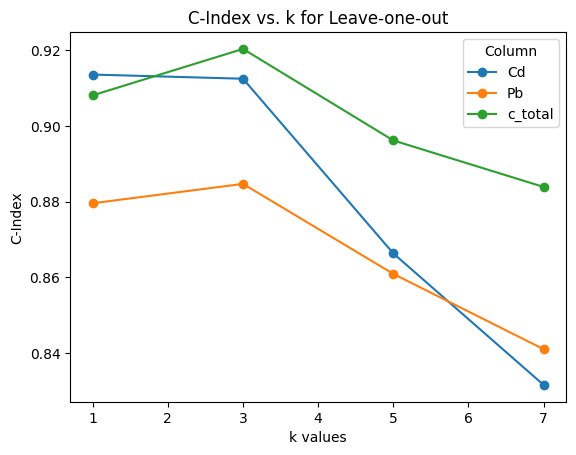

In [8]:
for name, group in grouped_loo_df:
    plt.plot(group['k'], group['C-index'], marker='o', linestyle='-', label=name)

plt.title('C-Index vs. k for Leave-one-out')
plt.xlabel('k values')
plt.ylabel('C-Index')
plt.legend(title='Column')
plt.show()

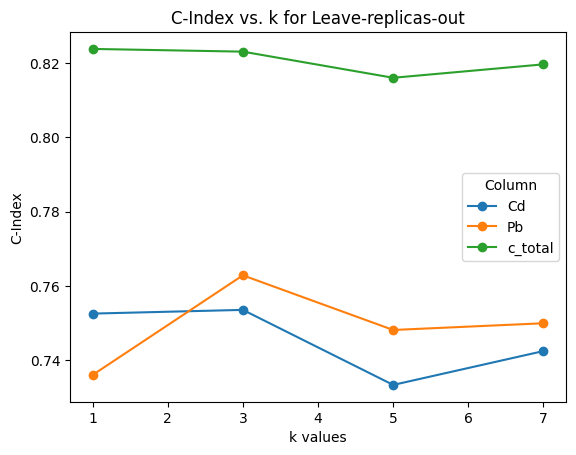

In [9]:
for name, group in grouped_logo_df:
    plt.plot(group['k'], group['C-index'], marker='o', linestyle='-', label=name)

plt.title('C-Index vs. k for Leave-replicas-out')
plt.xlabel('k values')
plt.ylabel('C-Index')
plt.legend(title='Column')
plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation method had more optimistic results? 
- Explain the reason for the optimistic results produced by the cross-validation method.
- Which cross-validation method generalized better on unseen data? Why?

#In this cell write your answers to the questions.
1. Leave-one-out had more optimistic results.
2. Leave-one-out uses one data point as an test sample each iteration. We know that there are at least 3 identical data points as the one we are using as test sample. In leave-replicas-out method there migth be no identical samples in the train set as in the test set.
3. Leave-one-out might be too optimistic and overfitted so Leave-replicas-out method could generalze the unseen data better. The higher c-index values implicate LOO to be the better of these two methods but seems to be little overfitted.